<a href="https://colab.research.google.com/github/raflial75/BatiQu/blob/machine-learning/%5BModel%5D%20Project_Batiqu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BATIQU: Multi-class Batik Classification

Welcome to this assignment! In this exercise, you will get a chance to work on a multi-class classification problem. You will be using the [Sign Language MNIST](https://www.kaggle.com/datamunge/sign-language-mnist) dataset, which contains 28x28 images of hands depicting the 26 letters of the English alphabet.

You will need to pre-process the data so that it can be fed into your convolutional neural network to correctly classify each image as the letter it represents.


Let's get started!

_**NOTE:** To prevent errors from the autograder, please avoid editing or deleting non-graded cells in this notebook . Please only put your solutions in between the `### START CODE HERE` and `### END CODE HERE` code comments, and refrain from adding any new cells._

In [1]:
#Import Libraries

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
import cv2
from tqdm import tqdm
import os
from random import shuffle
import shutil
from shutil import copyfile
from zipfile import ZipFile
from PIL import Image
import fnmatch
import string

Download the training and test sets (the test set will actually be used as a validation set):

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Define some globals with the path to both files you just downloaded:

In [3]:
import tensorflow as tf

# Define the directory for your dataset
dataset_directory = '/content/drive/MyDrive/Dataset_Batik/'

# Use tf.keras.preprocessing.image_dataset_from_directory to load and split the dataset
batch_size = 32
img_height = 224
img_width = 224
validation_split = 0.2
image_shape = (img_height, img_width, 3)

# Create the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_directory,
    validation_split=validation_split,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    labels='inferred'
)

# Create the validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_directory,
    validation_split=validation_split,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    labels='inferred'
)

# Print class names
class_names = train_dataset.class_names
print("Class names:", class_names)


Found 982 files belonging to 20 classes.
Using 786 files for training.
Found 982 files belonging to 20 classes.
Using 196 files for validation.
Class names: ['batik-bali', 'batik-betawi', 'batik-celup', 'batik-cendrawasih', 'batik-ceplok', 'batik-ciamis', 'batik-garutan', 'batik-gentongan', 'batik-kawung', 'batik-keraton', 'batik-lasem', 'batik-megamendung', 'batik-parang', 'batik-pekalongan', 'batik-priangan', 'batik-sekar', 'batik-sidoluhur', 'batik-sidomukti', 'batik-sogan', 'batik-tambal']


## Visualizing the numpy arrays

Now that you have converted the initial csv data into a format that is compatible with computer vision tasks, take a moment to actually see how the images of the dataset look like:

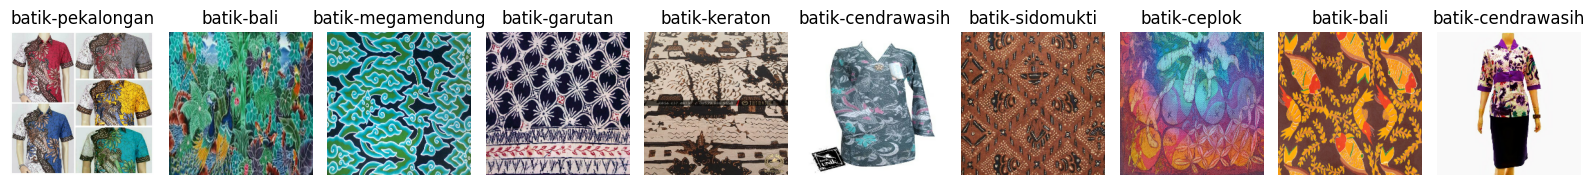

In [4]:
# Plot a sample of 10 images from the training set
def plot_categories(train_dataset, class_names):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for images, labels in train_dataset.take(1):
    for k in range(10):
      img = images[k].numpy()
      img = array_to_img(img)
      ax = axes[k]
      ax.imshow(img, cmap="Greys_r")
      ax.set_title(class_names[int(labels[k])])
      ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(train_dataset, class_names)

## Creating the generators for the CNN

Now that you have successfully organized the data in a way that can be easily fed to Keras' `ImageDataGenerator`, it is time for you to code the generators that will yield batches of images, both for training and validation. For this complete the `train_val_generators` function below.

Some important notes:

- The images in this dataset come in the same resolution so you don't need to set a custom `target_size` in this case. In fact, you can't even do so because this time you will not be using the `flow_from_directory` method (as in previous assignments). Instead you will use the [`flow`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow) method.
- You need to add the "color" dimension to the numpy arrays that encode the images. These are black and white images, so this new dimension should have a size of 1 (instead of 3, which is used when dealing with colored images). Take a look at the function [`np.expand_dims`](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html) for this.

In [27]:
train_dataset_='/content/drive/MyDrive/Dataset_Batik_Fix/train'
validation_dataset_='/content/drive/MyDrive/Dataset_Batik_Fix/val'

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tempfile
"""
Creates the training and validation data generators.
  Returns:
train_generator, validation_generator - tuple containing the generators
"""
# Instantiate the ImageDataGenerator class for training

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    rotation_range=90,
    fill_mode='reflect',
    zoom_range=0.2,
    brightness_range=[0.5, 1.5],
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)


# Pass in the appropriate arguments to the flow method for training
train_generator = train_datagen.flow_from_directory(
    directory=train_dataset,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=30,
    color_mode='rgb',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    directory=validation_dataset,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=30,
    color_mode='rgb'
)

class_names =list(train_generator.class_indices.keys())
print(f"Class: {class_names}")

Found 782 images belonging to 20 classes.
Found 199 images belonging to 20 classes.
Class: ['batik-bali', 'batik-betawi', 'batik-celup', 'batik-cendrawasih', 'batik-ceplok', 'batik-ciamis', 'batik-garutan', 'batik-gentongan', 'batik-kawung', 'batik-keraton', 'batik-lasem', 'batik-megamendung', 'batik-parang', 'batik-pekalongan', 'batik-priangan', 'batik-sekar', 'batik-sidoluhur', 'batik-sidomukti', 'batik-sogan', 'batik-tambal']


## Coding the CNN

One last step before training is to define the architecture of the model.

Complete the `create_model` function below. This function should return a Keras' model that uses the `Sequential` or the `Functional` API.

The last layer of your model should have a number of units equal to the number of letters in the English alphabet. It should also use an activation function that will output the probabilities per letter.

*Note: The [documentation](https://www.kaggle.com/datamunge/sign-language-mnist) of the dataset mentions that there are actually no cases for the last letter, Z, and this will allow you to reduce the recommended number of output units above by one. If you're not yet convinced, you can safely ignore this fact for now and study it later. You will pass the assignment even without this slight optimization.*

Aside from defining the architecture of the model, you should also compile it so make sure to use a `loss` function that is suitable for multi-class classification.

**Note that you should use no more than 2 Conv2D and 2 MaxPooling2D layers to achieve the desired performance.**

In [18]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    alpha=1.0,
    pooling='avg' # Add GlobalAvgPool2D() layer as its final layer
)

base_model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReL

In [19]:
base_model.trainable = False

In [30]:
# grader-required-cell
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from PIL import Image

# Create and compile your model
def create_model():
    DESIRED_ACCURACY = 0.85

    class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs = {}):
            if logs.get('accuracy') is not None and logs.get('accuracy') > DESIRED_ACCURACY:
              print("\nLoss is low so cancelling training!")
              self.model.stop_training = True
    callbacks = myCallback()
  ### START CODE HERE

  # Define the model
  # Use no more than 2 Conv2D and 2 MaxPooling2D
    model = Sequential()
    model.add(base_model)
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # You can adjust the learning rate as needed
        loss='categorical_crossentropy',  # Use categorical_crossentropy for multi-class classification
        metrics=['accuracy']
        )

  ### END CODE HERE

    return model, callbacks

In [32]:
model, callbacks = create_model()
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    batch_size=64,
    callbacks=[callbacks]  # Pass the custom callback here
)

Epoch 1/50
27/27 [==============================] - 82s 3s/step - loss: 3.2111 - accuracy: 0.0806 - val_loss: 2.9917 - val_accuracy: 0.0854
Epoch 2/50
27/27 [==============================] - 67s 2s/step - loss: 2.8400 - accuracy: 0.1304 - val_loss: 2.8055 - val_accuracy: 0.1508
Epoch 3/50
27/27 [==============================] - 75s 3s/step - loss: 2.5849 - accuracy: 0.2315 - val_loss: 2.6852 - val_accuracy: 0.1809
Epoch 4/50
27/27 [==============================] - 67s 2s/step - loss: 2.4807 - accuracy: 0.2558 - val_loss: 2.6008 - val_accuracy: 0.2161
Epoch 5/50
27/27 [==============================] - 68s 3s/step - loss: 2.3002 - accuracy: 0.3184 - val_loss: 2.5503 - val_accuracy: 0.2563
Epoch 6/50
27/27 [==============================] - 66s 2s/step - loss: 2.1800 - accuracy: 0.3657 - val_loss: 2.4724 - val_accuracy: 0.2864
Epoch 7/50
27/27 [==============================] - 66s 2s/step - loss: 2.1049 - accuracy: 0.3900 - val_loss: 2.4308 - val_accuracy: 0.3065
Epoch 8/50
27/27 [==

Now take a look at your training history:

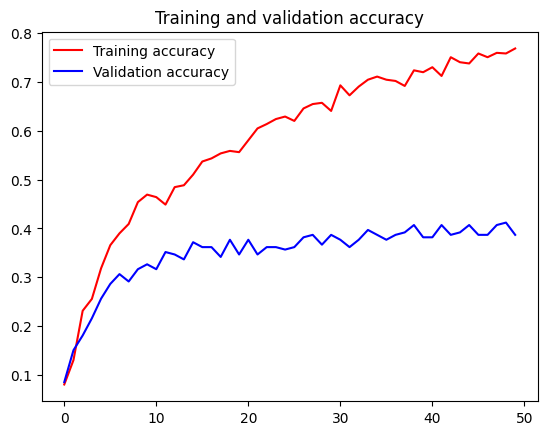

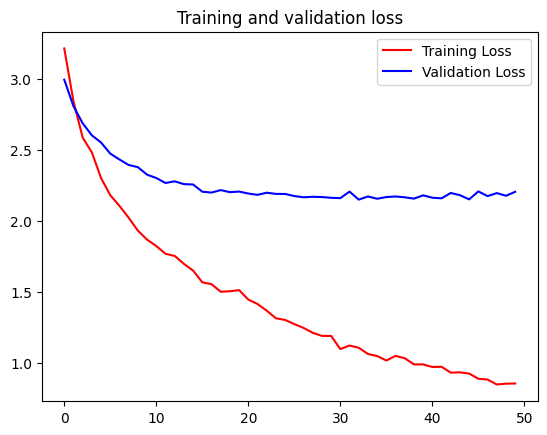

In [33]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

You will not be graded based on the accuracy of your model but try making it as high as possible for both training and validation, as an optional exercise, **after submitting your notebook for grading**.

A reasonable benchmark is to achieve over 99% accuracy for training and over 95% accuracy for validation within 15 epochs. Try tweaking your model's architecture or the augmentation techniques to see if you can achieve these levels of accuracy.

**Congratulations on finishing this week's assignment!**

You have successfully implemented a convolutional neural network that is able to perform multi-class classification tasks! Nice job!

**Keep it up!**